# 01: Data Profiling & Exploratory QoE Landscape

This notebook performs data quality checks and explores the QoE landscape.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.telecom_qoe_analytics.data_loader import load_all, validate_datasets, setup_plotting, missing_report, quick_stats

setup_plotting(context="paper", palette="deep", style="ticks")
datasets = load_all()

📈 Plotting environment set: style=ticks, palette=deep, context=paper


## 1. Schema Validation

In [2]:
validation_results = validate_datasets(datasets)
print("Schema Validation Results:", validation_results)

Schema Validation Results: {'users': True, 'cells': True, 'sessions': True}


### 💡 How to read this: Schema Validation
* **What we are looking for:** Are all columns present? Do they have the right data types?
* **Why it matters:** If `session_id` is a number in one table and a string in another, the `merge` will fail.
* **Success Criteria:** All tables should return `True`. If `False`, check for renamed or missing columns in your source parquet files.


## 2. Missing Value Analysis

In [3]:
for name, df in datasets.items():
    report = missing_report(df)
    if not report.empty:
        print(f"\nMissing values in {name}:")
        display(report)
    else:
        print(f"No missing values in {name}")

No missing values in users
No missing values in cells
No missing values in sessions


### 💡 How to read this: Missing Values
* **Missing Pct:** If a column has >40% missing values (like `episode_hours` often does), it might be too sparse for a machine learning model.
* **Interpretation:** 
    * **Network-scoped events:** It's normal for `user_id` to be missing if the event is a general cell tower outage.
    * **Systematic gaps:** If `throughput` is missing only for `5G`, there's likely a logging bug in the 5G sensors.


## 3. QoE Distribution Analysis

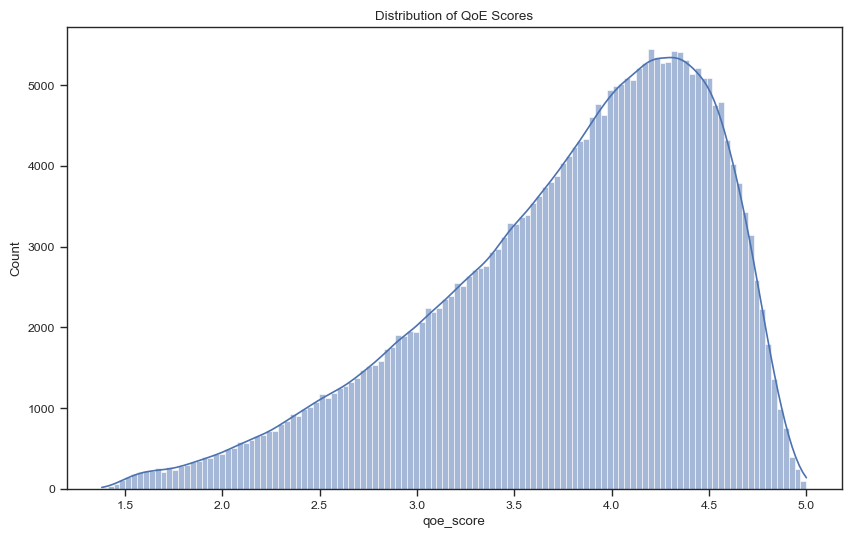

In [4]:
sessions = datasets["sessions"]
plt.figure(figsize=(10, 6))
sns.histplot(sessions["qoe_score"], kde=True)
plt.title("Distribution of QoE Scores")
plt.show()

### 💡 How to read this: QoE Distribution
* **The Shape:** 
    * **Normal (Bell Curve):** Most users have average experience. 
    * **Bimodal (Two peaks):** You have two distinct user groups (e.g., 'Happy' users and 'Suffering' users).
* **The KDE line:** This is a smooth version of the bars. It helps identify the **skewness**. If the "tail" is long toward 0, you have a critical mass of users with poor quality.


## 4. QoE by App Type

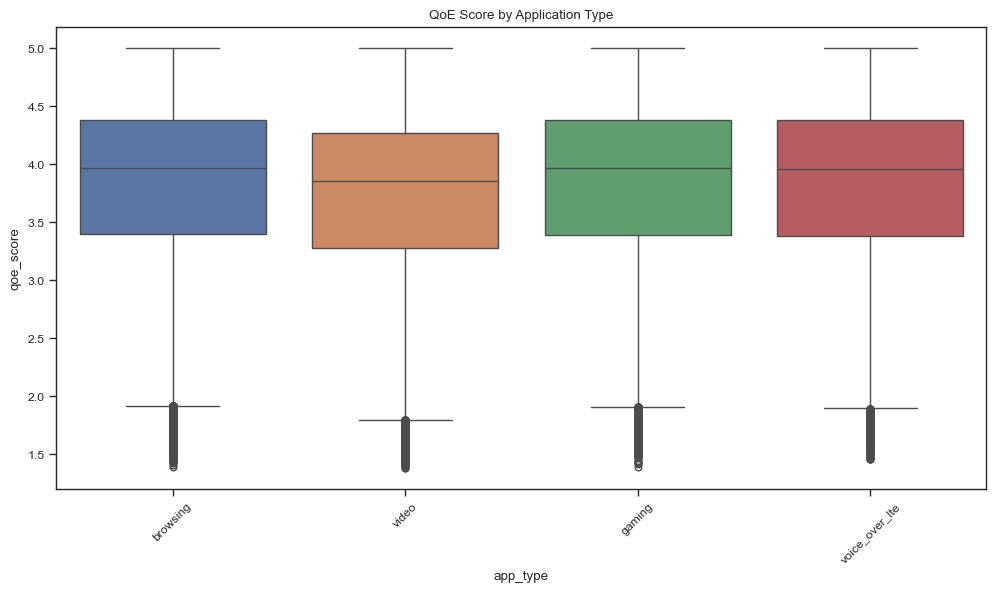

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sessions, x="app_type", y="qoe_score", hue="app_type")
plt.title("QoE Score by Application Type")
plt.xticks(rotation=45)
plt.show()

### 💡 How to read this: Boxplots (QoE by App)
* **The Center Line:** This is the **median**. If Video has a lower median than Chat, Video is your priority problem.
* **The Box:** Contains the middle 50% of the data. A "tall" box means high variability (inconsistent experience).
* **The Dots (Outliers):** These represent extreme cases. While we ignore them for averages, in Telecom, these "unlucky" users are the ones most likely to churn.


## 5. Diurnal Patterns

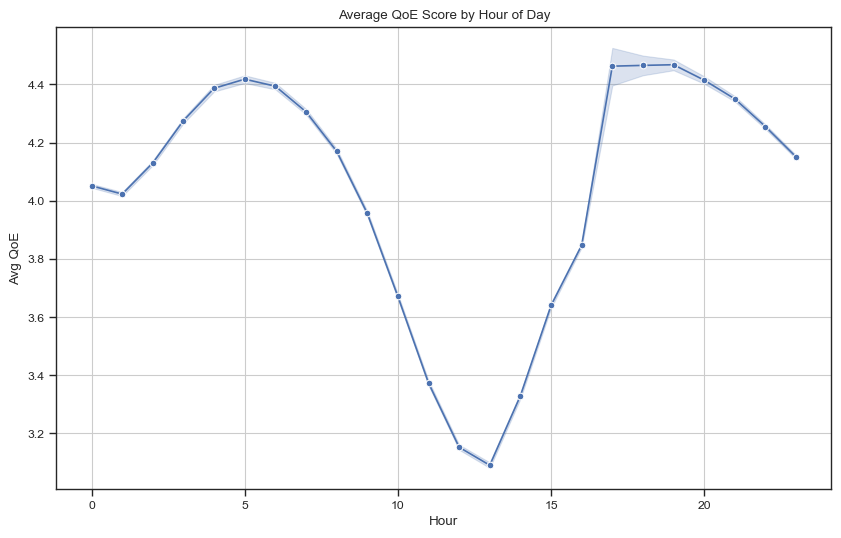

In [6]:
sessions["hour"] = sessions["timestamp_start"].dt.hour
hourly_qoe = sessions.groupby("hour")["qoe_score"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=sessions, x="hour", y="qoe_score", marker="o", errorbar=("ci", 95))
plt.title("Average QoE Score by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg QoE")
plt.grid(True)
plt.show()

### 💡 How to read this: Diurnal Trends (Daily Repeating Patterns)
* **The Trend:** Usually, QoE drops in the busy hours due to high network congestion as people stream movies.
* **The Shaded Area (95% CI):** This is the **Confidence Interval**. 
    * **Narrow shade:** We are very sure about this average.
    * **Wide shade:** Data is noisy or sample size is small at that hour. Don't base big decisions on wide-shaded areas!
